# Feature Selection and Engineering

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import OrdinalEncoder

## Importing the datasets

We won't use the test data to inform any of our feature engineering, but we will apply any transformations to both of the datasets.

In [2]:
train = pd.read_csv('training_data.csv', low_memory = False)
test = pd.read_csv('test_data.csv')
combined = [train, test]

pd.options.mode.chained_assignment = None

## Feature Selection

We have a dataset with 37 features and 1 predictor (casualty_severity). This is quite a lot of features that we know our baseline classified was overfitting to. Time to get selective with what we're going to include in our model.


### Dropping columns with no / little predictive power
Let's drop those unique indexer columns.

In [3]:
for dataset in combined:
  dataset.drop(labels=['accident_index', 'accident_severity', 'geometry'], axis=1, inplace=True)

Now we will dig into the Variance of each column. This will allow us to remove columns which are constant or quasi-constant and unlikely to hold any predictive power. Our threshold will drop columns which are 90% or more similar. We need to be a little bit careful, considering the imbalance in our predictor - although there may be low variance in these features, they may still be important.

First, we need to encode the categorical columns.

In [4]:
ord_encoder = OrdinalEncoder()
enc_train = pd.DataFrame(ord_encoder.fit_transform(train), columns=train.columns)
var = VarianceThreshold(threshold=0.1)
var.fit(enc_train)
low_variance_cols = [x for x in train.columns if x not in train.columns[var.get_support()]]
print(low_variance_cols)

['trunk_road_flag', 'bus_or_coach_passenger', 'pedestrian_road_maintenance_worker']


These features are showing as almost constant so let's get rid.

In [5]:
[dataset.drop(labels=low_variance_cols, axis=1, inplace=True) for dataset in combined]

[None, None]

Down to 31 features - great work! Let's keep going.

Let's have a look whether any of our features are highly correlated using the Pearson correlation coefficient.

In [6]:
corr_matrix = enc_train.corr()
upper = abs(corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)))
high_corr = [x for x in upper.columns if any(upper[x] > 0.75)]
print(high_corr)

['local_authority_highway', 'lsoa_of_accident_location']


From our EDA we know that these two columns, along with the local_authority_district column, contain essentially the same information (the region of the crash). We can therefore drop 2 of the 3 columns.

In [7]:
[dataset.drop(labels=high_corr, axis=1, inplace=True) for dataset in combined]

[None, None]

29 features!

We have both age_of_casualty and age_band_of_casualty. Our age_of_casualty is right skewed, so we can either transform the data or use the binned ages. Here, we will use the age_band_of_casualty. We will also drop the entries where we are missing the ages as we know from our baseline classifier that this in an important predictor.

In [8]:
[dataset.drop('age_of_casualty', axis=1, inplace=True) for dataset in combined]
for dataset in combined:
  dataset.drop(dataset[dataset.age_band_of_casualty.str.contains('Data missing')].index, inplace=True)

Let's also drop the 'Year', 'Month', and 'Day' features to prevent overfitting to the date of the worst crashes. We can revisit this decision if we need to.

In [9]:
[dataset.drop(labels=['Year', 'Month', 'Day'], axis=1, inplace=True) for dataset in combined]

[None, None]

25 features!

## Feature Engineering

We've done some __feature selection__ and cut out a handful of columns that are unlikely to be useful to us. Now we can look to __feature engineering__ to create / modify the remaining features into more predictive variables.

* By the looks of it, we still have a few columns that are likely to contain similar information. Casualty_class and casualty_type likely contain a bunch of similar information. Also, car_passenger could be combined into this data.

* Crashes are likely to be more serious if the casualty is a pedestrian or cyclist hit by a vehicle. How can we best represent this as a feature in our data? Is there more predictive power if we transform / combine the number_of_vehicles and number_of_casualties?

* From our EDA, we have a few outlier events with many vehicles / casualties. Let's test whether these are indeed outliers, and if so remove them from the dataset.

### Fencing upper values to remove outliers

In [10]:
def cap_upper_values(train, test, column):
  IQR = train[column].quantile(0.75) - train[column].quantile(0.25)
  upper_bound = np.floor(train[column].quantile(0.75) + (IQR * 3))
  train.loc[train[column] > upper_bound, column] = upper_bound
  test.loc[test[column] > upper_bound, column] = upper_bound 

In [11]:
cap_upper_values(train, test, 'number_of_casualties')

for dataset in combined:
  dataset.loc[(dataset.number_of_vehicles > 3), 'number_of_vehicles'] = 3

### Combining features

The 'casualty_type' column contains some more granular information about the casualties. Here, casualties are seperated into the following groups:
* Car occupant
* Van / Goods vehicle (3.5 tonnes mgw or under) occupant
* Motorcycle over 500cc rider or passenger
* Cyclist
* Pedestrian
* Taxi/Private hire car occupant
* Bus or coach occupant (17 or more pass seats)
* Motorcycle 125cc and under rider or passenger
* Motorcycle 50cc and under rider or passenger
* Mobility scooter rider
* Motorcycle - unknown cc rider or passenger
* Other vehicle occupant
* Motorcycle over 125cc and up to 500cc rider or passenger
* Electric motorcycle rider or passenger
* Good vehicle (over 3.5t. and under 7.5t.) occupant
* Good vehicle (unknown weight) occupant
* Minibus (8 - 16 passenger seats) occupant
* Tram occupant
* Horse rider
* Agricultural vehicle occupant

Wow, that is a lot of information!

Let's combine the 'casualty_class' and 'casualty_type' columns to create more granular information about the casualties (whether they are the driver or passengers, and whether they are a cyclist). We can then also combine the 'car_passenger' feature to determine whether they are front or rear seat passengers. __First, we'll need to fill in the missing values in the 'car_passenger' category__. All missing data in the car_passengers column is for 'car occupant' casualty_types, so we will fill with the most frequent value (front passenger)

We will:
1. Differentiate between drivers and passengers for all vehicle types.
2. Combine motorcycle categories.
3. Combine minibus drivers and passengers into car drivers and passengers.
4. Combine goods vehicle categories.
5. Combine bus, taxi, and tram categories as public transports (drivers or passengers).
6. Horse rider, Agricultural vehicle occupant, and Mobility scooter rider contain little information, so we will combine those into the 'Other vehicle occupant category'.

Down the line, we may want to reduce the number of categories and roll up the less frequent types into one 'Other' category, or combine the large vehicles together.

In the cell below we will combine and relabel our new categories (albeit in quite a hacky way).

Then we can drop the 'casualty_class' and 'car_passengar' columns.

In [12]:
for dataset in combined:
  dataset.loc[(dataset.casualty_class == 'Driver or rider') & ((dataset.casualty_type == 'Car occupant') | (dataset.casualty_type == 'Minibus (8 - 16 passenger seats) occupant')), 'casualty_type'] = 'Car driver'
  dataset.loc[(dataset.casualty_class == 'Passenger') & ((dataset.casualty_type == 'Car occupant') | (dataset.casualty_type == 'Minibus (8 - 16 passenger seats) occupant')), 'casualty_type'] = 'Car passenger'
  dataset.loc[(dataset.casualty_class == 'Driver or rider') & (dataset.casualty_type.str.contains('motorcycle', case = False)), 'casualty_type'] = 'Motorcycle rider'
  dataset.loc[(dataset.casualty_class == 'Passenger') & (dataset.casualty_type.str.contains('motorcycle', case = False)), 'casualty_type'] = 'Motorcycle passenger'

  dataset.loc[dataset.casualty_type.str.contains('goods vehicle', case = False), 'casualty_type'] = 'Goods vehicle occupant'
  dataset.loc[dataset.casualty_type.str.contains('bus|taxi|tram', case = False), 'casualty_type'] = 'Public transport occupant'
  dataset.loc[dataset.casualty_type.str.contains('mobility|agricultural|horse', case = False), 'casualty_type'] = 'Other vehicle occupant'


  dataset.loc[(dataset.casualty_class == 'Driver or rider') & (dataset.casualty_type == 'Goods vehicle occupant'), 'casualty_type'] = 'Goods vehicle driver'
  dataset.loc[(dataset.casualty_class == 'Passenger') & (dataset.casualty_type == 'Goods vehicle occupant'), 'casualty_type'] = 'Goods vehicle passenger'

  dataset.loc[(dataset.casualty_class == 'Driver or rider') & (dataset.casualty_type == 'Public transport occupant'), 'casualty_type'] = 'Public transport driver'
  dataset.loc[(dataset.casualty_class == 'Passenger') & (dataset.casualty_type == 'Public transport occupant'), 'casualty_type'] = 'Public transport passenger'

  dataset.loc[dataset.car_passenger.str.contains('unknown|missing', case=False), 'car_passenger'] = 'Front seat passenger'
  dataset.loc[(dataset.casualty_type == 'Car passenger') & (dataset.car_passenger == 'Front seat passenger'), 'casualty_type'] = 'Car front seat passenger'
  dataset.loc[(dataset.casualty_type == 'Car passenger') & (dataset.car_passenger == 'Rear seat passenger'), 'casualty_type'] = 'Car rear seat passenger'
  dataset.loc[(dataset.casualty_type == 'Car passenger'), 'casualty_type'] = 'Car front seat passenger'
  dataset.drop(labels='car_passenger', axis=1, inplace=True)

  dataset.drop(labels='casualty_class', inplace=True, axis=1)

### Transforming features

* Pedal cycles are classified as 'vehicles' in the dataset, yet crashes are more likely to be fatal if an engine-powered vehicle is hitting a cyclist - this might not be captured so well if the cycle is counted as another vehicle.

In [13]:
for dataset in combined:
  dataset.loc[(dataset.casualty_type == 'Cyclist'), 'number_of_vehicles'] = dataset.number_of_vehicles.apply(lambda x: x-1)

* The 'darkness' conditions in our light_conditions feature can be combined.

In [14]:
for dataset in combined:
  dataset.loc[(dataset.light_conditions != 'Darkness - lights lit') & (dataset.light_conditions.str.contains('darkness', case=False)), 'light_conditions'] = 'Darkness'

* Although 'time' is a numeric column, 18 (18:00) is not meaningfully 'greater' than 6 (06:00). We should convert the time into categories, perhaps binned into rush hour, daytime, and nighttime.

In [15]:
rush_hours = [7, 8, 9, 10, 16, 17, 18, 19]
night_hours = [21, 22, 23, 0, 1, 2, 3, 4, 5, 6]
weekend = ['Saturday', 'Sunday']

for dataset in combined:
  dataset.loc[(~dataset.day_of_week.isin(weekend)) & (dataset.time.isin(rush_hours)), 'time'] = 'rush hour'
  dataset.loc[dataset.time.isin(night_hours), 'time'] = 'nighttime'
  dataset.loc[(dataset.day_of_week.isin(weekend)) & (dataset.time != 'nighttime'), 'time'] = 'daytime'
  dataset.loc[~dataset.time.isin(['rush hour', 'daytime', 'nighttime']), 'time'] = 'daytime'

C:\Users\Elena\AppData\Local\Temp\ipykernel_21920\4153107159.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'rush hour' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  dataset.loc[(~dataset.day_of_week.isin(weekend)) & (dataset.time.isin(rush_hours)), 'time'] = 'rush hour'


### Handling missing data 

#### Random imputation of missing values
* There are a lot of missing values in the casualty_imd_decile and casualty_home_area_type columns that we will randomly impute as the data seems to be MCAR.

In [16]:
def random_imputer(dataset, column):
  mask = dataset[column].str.contains('Data missing', case=False)
  non_nan_vals = dataset.loc[~mask, column]
  dataset.loc[mask, column] = non_nan_vals.sample(n = mask.sum(), replace=True).tolist()


for dataset in combined:
  random_imputer(dataset, 'casualty_imd_decile')
  random_imputer(dataset, 'casualty_home_area_type')

#### Filling missing values with most frequent catagory
* pedestrian_crossing_human_control, pedestrian_crossing_physical_facilities, and road_surface_conditions have a few rows with missing data that can be infilled with the most frequent value.

In [17]:
for dataset in combined:
  missing_data_cols = [col for col in dataset.select_dtypes(include="object") if dataset[col].str.contains('missing|unknown', case=False, na=False).any()]
  for col in missing_data_cols:
    dataset.loc[dataset[col].str.contains('missing|unknown', case=False, na=False), col] = dataset[col].value_counts().sort_values(ascending=False).index[0]

* Two features have unseen categories in the testing data. Let's combine infrequent categories to try and iron these out.

In [18]:
rare_vals = train.pedestrian_location.value_counts(normalize=True).lt(0.01)
rare_vals = rare_vals[rare_vals == True].index
print(rare_vals)

Index(['In centre of carriageway - not on refuge, island or central reservation',
       'Crossing elsewhere within 50m. of pedestrian crossing',
       'On refuge, central island or central reservation',
       'Crossing in zig-zag approach lines'],
      dtype='object', name='pedestrian_location')


In [19]:
diff_cols = ['pedestrian_location', 'road_surface_conditions']
for dataset in combined:
  for col in diff_cols:
    rare_vals = dataset[col].value_counts(normalize=True).lt(0.01)
    rare_vals = rare_vals[rare_vals == True].index
    dataset.loc[(dataset[col].isin(rare_vals)), col] = 'Other'


## Encoding features

* We have some ordinal categories and a couple of boolen categories (0 or 1)

In [20]:
road_class = {'Not at junction or within 20 metres': 0, 'Unclassified': 1, 'C': 2, 'B': 3, 'A': 4, 'A(M)': 5, 'Motorway': 6}
day_of_week_ordinal = {'Monday': 0, 'Tuesday': 1, 'Wednesday': 2, 'Thursday': 3, 'Friday': 4, 'Saturday': 5, 'Sunday': 7}
imd_ordinal = {'Most deprived 10%': 0, 'More deprived 10-20%': 1, 'More deprived 20-30%': 2, 'More deprived 30-40%': 3, 'More deprived 40-50%': 4, 'Less deprived 40-50%': 5, 'Less deprived 30-40%': 6, 'Less deprived 20-30%': 7, 'Less deprived 10-20%': 8, 'Least deprived 10%': 9}
age_ordinal = {'0 - 5': 0, '6 - 10': 1, '11 - 15': 2, '16 - 20': 3, '21 - 25': 4, '26 - 35': 5, '36 - 45': 6, '46 - 55': 7, '56 - 65': 8, '66 - 75': 9, 'Over 75': 10}

sex_bool = {'Male': 0, 'Female': 1}
urban_rural_bool = {'Urban': 0, 'Rural': 1}

for dataset in combined:
  dataset.first_road_class.replace(road_class, inplace=True)
  dataset.second_road_class.replace(road_class, inplace=True)
  dataset.day_of_week.replace(day_of_week_ordinal, inplace=True)
  dataset.casualty_imd_decile.replace(imd_ordinal, inplace=True)
  dataset.age_band_of_casualty.replace(age_ordinal, inplace=True)
  dataset.sex_of_casualty.replace(sex_bool, inplace=True)
  dataset.urban_or_rural_area.replace(urban_rural_bool, inplace=True)



* And categorical cols to be one hot encoded

In [21]:
cols_to_OHE = train.select_dtypes(include='object').columns.to_list()
target_var = 'casualty_severity'
cols_to_OHE.remove(target_var)

train = pd.get_dummies(train, columns=cols_to_OHE)
test = pd.get_dummies(test, columns=cols_to_OHE)

* Finally, let's encode our predictor

In [22]:
severity_dict = {'Slight': 0, 'Serious': 1, 'Fatal': 1}

train['casualty_severity'].replace(severity_dict, inplace=True)
test['casualty_severity'].replace(severity_dict, inplace=True)


Well, we have an order of magnitude less features than for our baseline classifier, so that's something!

In [23]:
train.to_csv('prepared_training_data.csv', index=False)
test.to_csv('prepared_test_data.csv', index=False)


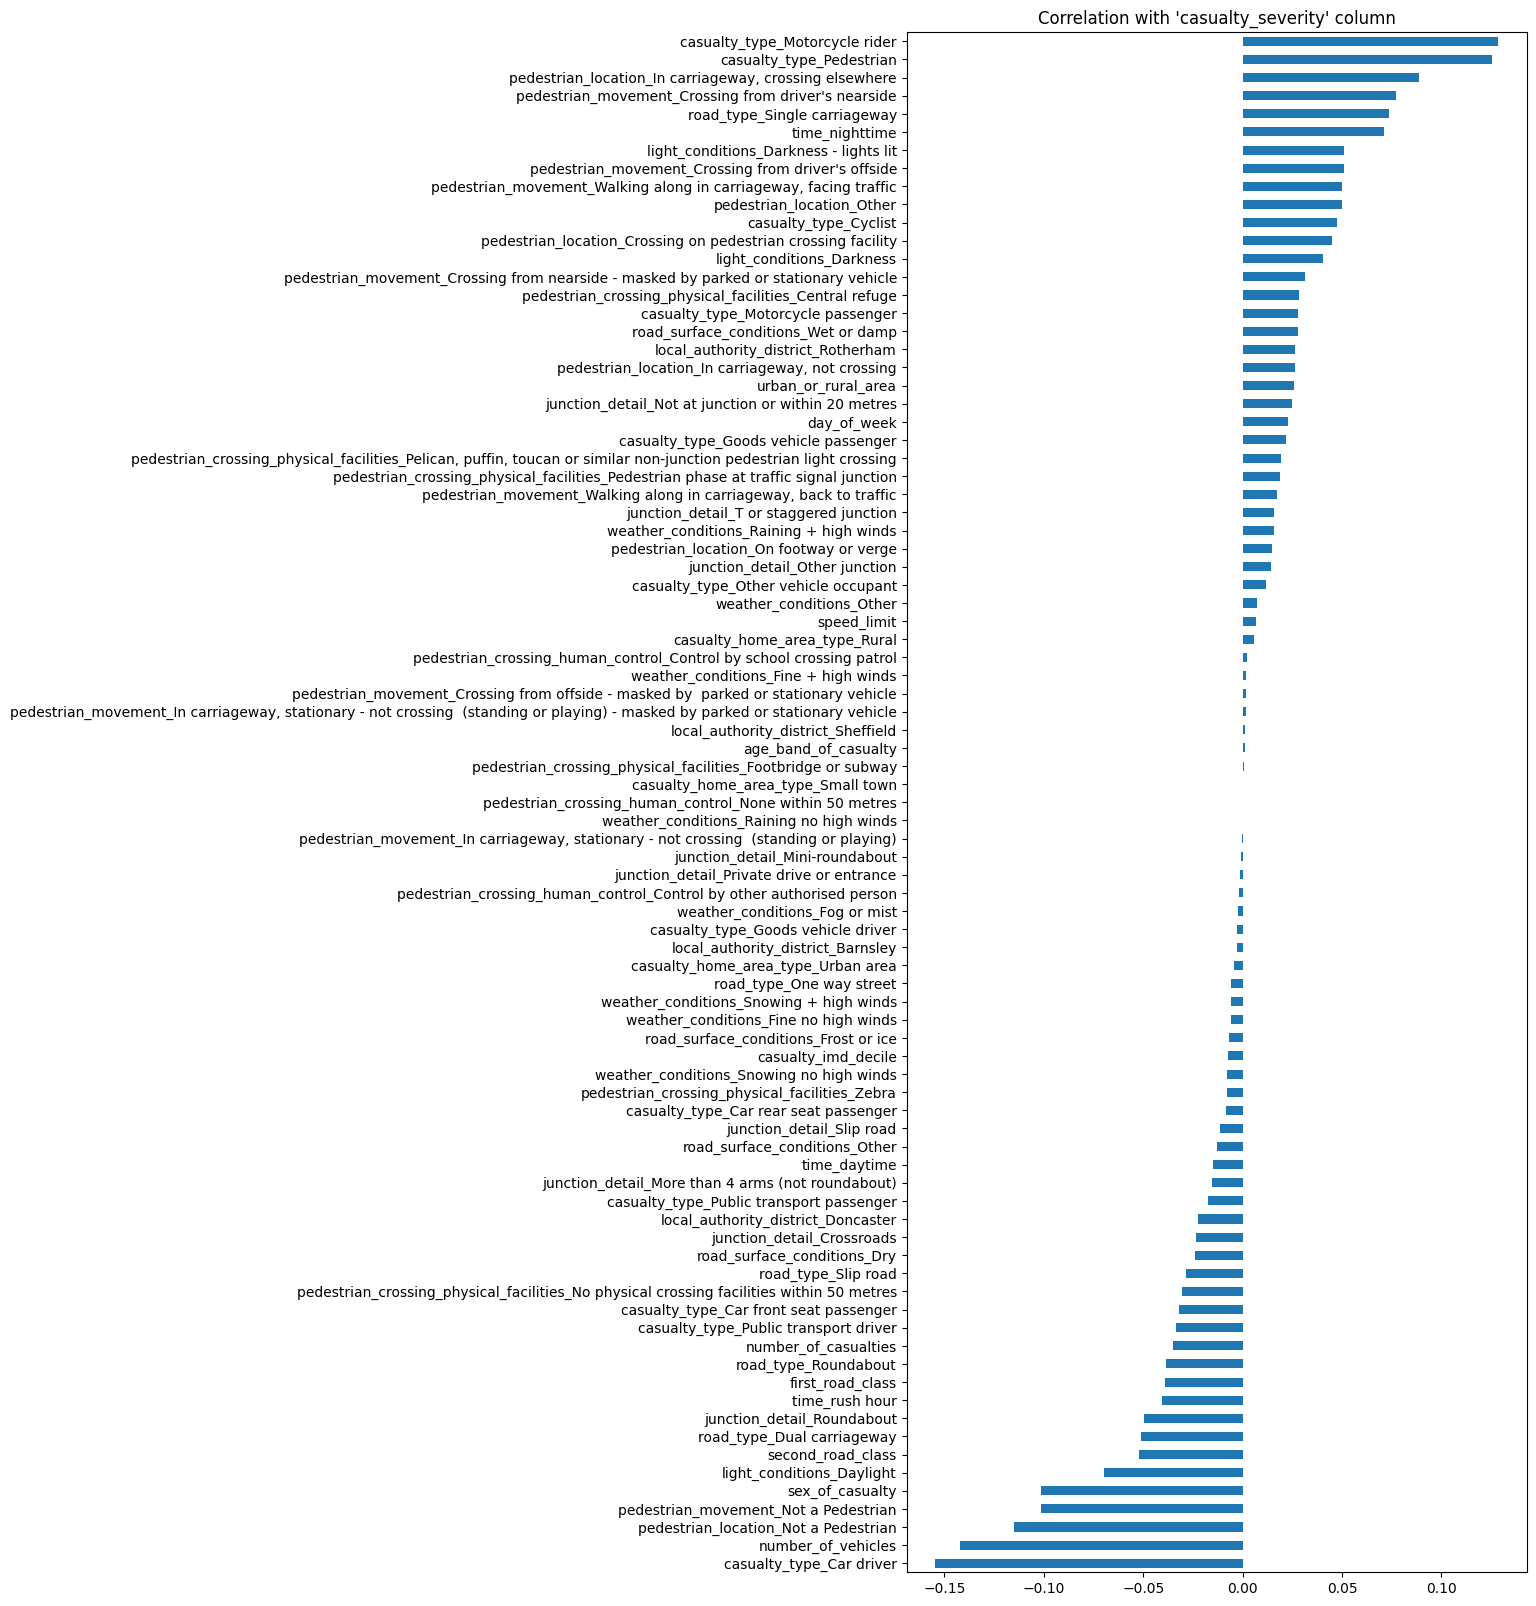

In [27]:
X = train.drop(columns=['casualty_severity'], axis=1)

plt.figure(figsize=(8, 20))
X.corrwith(train['casualty_severity']).sort_values().plot(kind='barh', 
                               title="Correlation with 'casualty_severity' column")
plt.show()